# This notebook is investigating TB tseries and histograms for the Hunza met station locations




## Load in all the modules needed

In [1]:
%pylab notebook
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
import rasterio
from cetbtools.ease2conv import Ease2Transform
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# navigate to where scripts are saved
%cd /projects/brodzik/ipynb_melt_onset/scripts/
%ls

/projects/brodzik/ipynb_melt_onset/scripts
CETB_algorithms.py  CETB_analysis.py~       __pycache__/
CETB_analysis.py    CETB_read_functions.py


In [3]:
# load the custom functions
from CETB_read_functions import read_Tb
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_UIB_cube_offset
from CETB_read_functions import grid_locations_of_UIB
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array
from CETB_analysis import MOD_array_year

In [4]:
# Set pixel lookups by met station
# ref: /Users/brodzik/Desktop/GIS_data/Pakistan/Hunza/wapda_met_stations_CETBlocs.v4.xlsx
Khunjerab = {"name": "Khunjerab",
             "lat": 36.8411,
             "lon": 75.4192,
             "elevation": 4440,
             "row3km": 220,
             "col3km": 41,
             "row25km": 27,
             "col25km": 5
           }

In [5]:
# Set pixel lookups by met station
# ref: /Users/brodzik/Desktop/GIS_data/Pakistan/Hunza/wapda_met_stations_CETBlocs.v4.xlsx
Ziarat = {"name": "Ziarat",
             "lat": 36.798,
             "lon": 74.482,
             "elevation": 3020,
             "row3km": 249,
             "col3km": 34,
             "row25km": 31,
             "col25km": 4
           }

In [6]:
# Set pixel lookups by met station
# ref: /Users/brodzik/Desktop/GIS_data/Pakistan/Hunza/wapda_met_stations_CETBlocs.v4.xlsx
Naltar = {"name": "Naltar",
          "lat": 36.1667,
          "lon": 74.1833,
          "elevation": 2898,
          "row3km": 264,
          "col3km": 51,
          "row6km": 132,
          "col6km": 26,
          "row25km": 33,
          "col25km": 6
           }

In [ ]:
# Set up cartopy CRSs for E2N and 
# for UIB cubes, I want to rotate 90 degrees clockwise
geod = ccrs.Geodetic()
e2n = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
e2nRotate = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0, central_longitude=90.0)

# Sanity check
lon, lat = geod.transform_point(
    x = -9000000.,
    y = 9000000.,
    src_crs=e2n)
print("E2N UL corner lon=%.4f, lat=%.4f" % (lon, lat))

In [ ]:
DEM25kmFile = '/work/charis/ti_model/SRTMGL3_version2_EASE2/EASE2_N25km.CHARIS_DEM_v2_IN.UIB_Khan_clip.mode.tif'
with rasterio.open(DEM25kmFile) as src:
    dem25km = np.squeeze(src.read())
DEM3kmFile = '/work/charis/ti_model/SRTMGL3_version2_EASE2/EASE2_N3.125km.CHARIS_DEM_v2_IN.UIB_Khan_clip.mode.tif'
with rasterio.open(DEM3kmFile) as src:
    dem3km = np.squeeze(src.read())

## Read TB data

In [53]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='UIB'  #make this the same syntax as cubefilenames and sub-directory
platform='F19'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sensor='SSMIS'  #'AMSRE', 'SSMI', etc.
channel='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
version='v1.3'
proj='N'

if sensor=='SSMI':
    provider='CSU' 
elif sensor=='AMSRE':
    provider='RSS'

cubeDir = '/work/PMESDR/CETB_v1.3/%s_%s/%s/cubes_%s/' % (platform, sensor, proj, region)    

# prefix filepath
prefix_GRD = 'CETB.cubefile.%s.%s_%s-%s-GRD-%s-%s' % (region, platform, sensor, channel, provider, version)
prefix_SIR = 'CETB.cubefile.%s.%s_%s-%s-SIR-%s-%s' % (region, platform, sensor, channel, provider, version)

# years for each sensor
# F13, May 95 - Nov 09
if platform=='F08':
    # F08, Aug 87 - Dec 91
    Years = [1988, 1989, 1990, 1991]
elif platform=='F10':
    # F10, Dec 90 - Nov 97
    Years = [1991, 1992, 1993, 1994, 1995, 1996, 1997]
elif platform=='F11':
    # F11, Dec 91 - May 00
    Years = [1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
elif platform=='F13':
    # F13, May 95 - Nov 09
    Years = [1996, 1997, 1998, 1999, 2000, 2001,2002,2003,2004,2005,2006,2007,2008,2009]
elif platform=='F14':
    # F14, May 97 - Aug 08
    Years=[1998, 1999, 2000, 2001,2002,2003,2004,2005,2006,2007]
elif platform=='F15':
    # F15, Feb 00 - Jun 17
    Years=[2001, 2002,2003,2004,2005,2006,2007,2008,2009,2010,2011, 2012,2013, 2014, 2015, 2016]
elif platform=='F16':
    # F16, Nov 05 - Jun 17
    Years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
elif platform=='F17':
    # F17, Mar 08 - Jun 17
    Years=[2009,2010,2011,2012,2013,2014,2015,2016]
elif platform=='F18':
    # F18, Mar 10 - Jun 17
    Years=[2011, 2012, 2013, 2014, 2015, 2016]
elif platform=='F19':
    # F19, Nov 14 - Feb 16
    Years=[2015]
elif platform=='AQUA':
    # AQUA AMSR-E: Jun 02 - Oct 11
    Years=[2003,2004,2005,2006,2007,2008,2009,2010,2011]


In [54]:
if sensor == 'AMSRE':
    window=10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
    DAV_threshold=40
    Tb_threshold=252
elif sensor == 'SSMI':
    window=14   # use 7 days for SSMI?
    DAV_threshold=18
    Tb_threshold=246
else:
    window=10   # not sure about SSMIS
    DAV_threshold=18
    Tb_threshold=246
count=3    # number of Tb/DAV exceedances to trigger MOD

In [55]:
# load in SIR TB data for the requested station
data_SIR=read_Tb(cubeDir, prefix_SIR, Years)
CETB_SIR=data_SIR['TB']   # 3-D Tb time-series array of TB

# load GRD Tb data
data_GRD=read_Tb(cubeDir, prefix_GRD, Years)
CETB_GRD=data_GRD['TB']

No subset specified, fetching complete cube...
Next filename=/work/PMESDR/CETB_v1.3/F19_SSMIS/N/cubes_UIB/CETB.cubefile.UIB.F19_SSMIS-37V-SIR-CSU-v1.3.2015.TB.nc...
No subset specified, fetching complete cube...
Next filename=/work/PMESDR/CETB_v1.3/F19_SSMIS/N/cubes_UIB/CETB.cubefile.UIB.F19_SSMIS-37V-GRD-CSU-v1.3.2015.TB.nc...


## For each station, fetch the data there and plot it as tseries and histogram

{'name': 'Khunjerab', 'lat': 36.8411, 'lon': 75.4192, 'elevation': 4440, 'row3km': 220, 'col3km': 41, 'row25km': 27, 'col25km': 5}


<IPython.core.display.Javascript object>


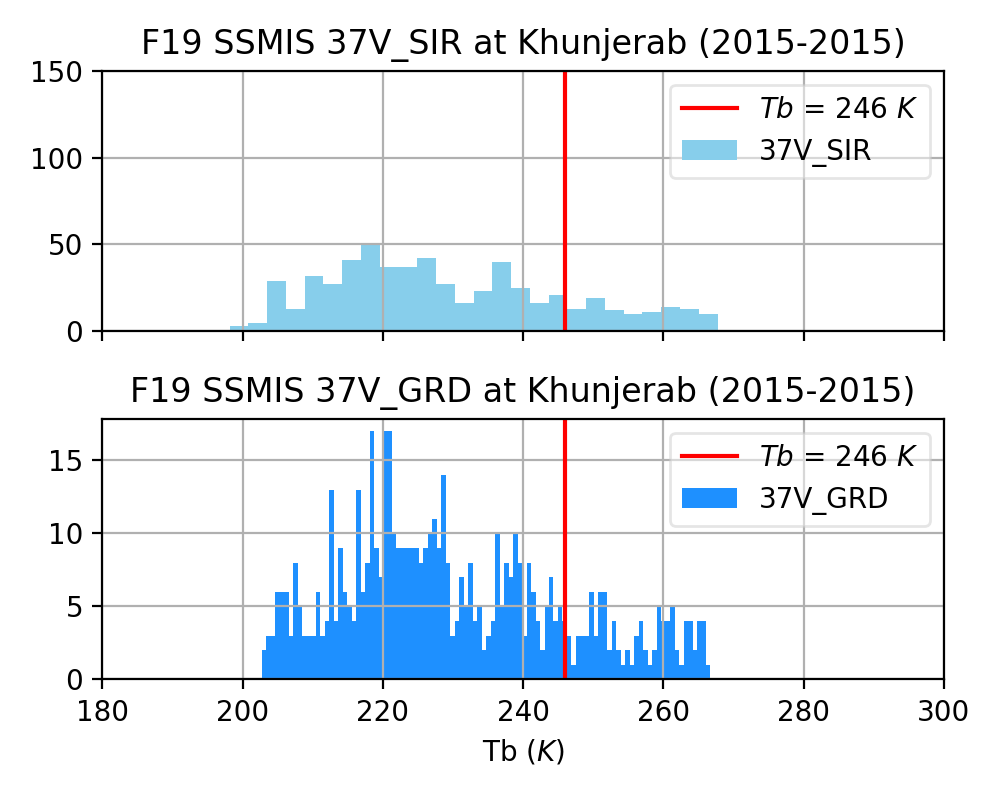

Saved hist to /projects/brodzik/pmesdr_melt_onset/data/Khunjerab_F19_SSMIS_2015-2015_37V_rSIR_vs_GRD_TB_hist.png
{'name': 'Ziarat', 'lat': 36.798, 'lon': 74.482, 'elevation': 3020, 'row3km': 249, 'col3km': 34, 'row25km': 31, 'col25km': 4}


<IPython.core.display.Javascript object>


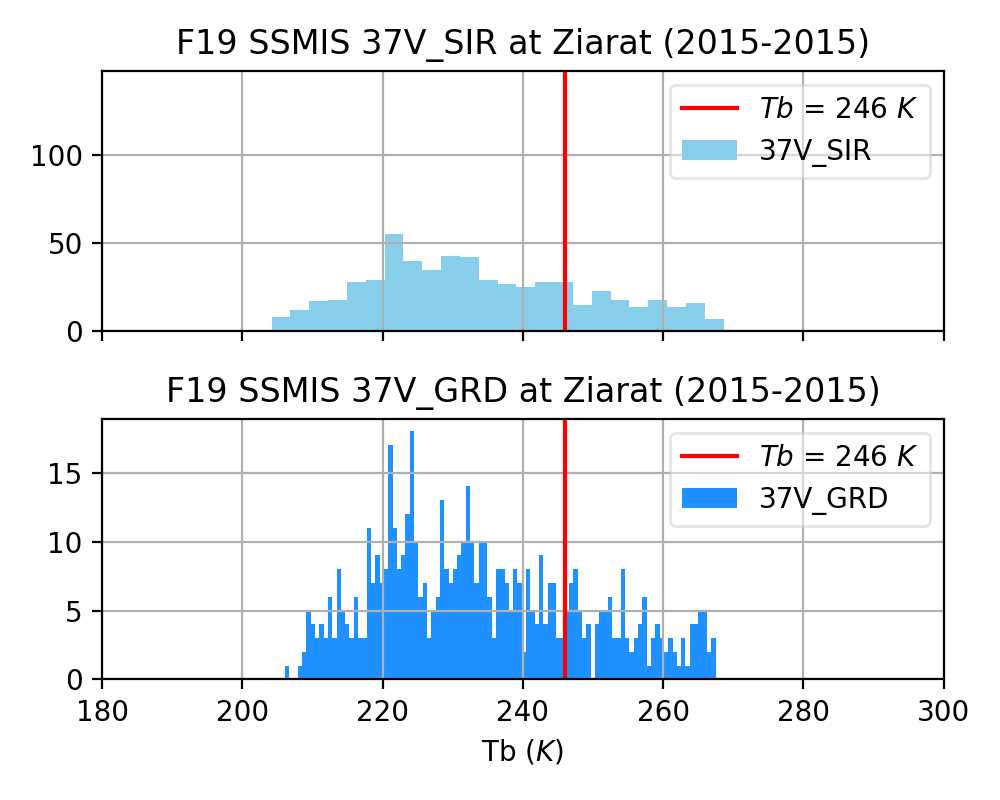

Saved hist to /projects/brodzik/pmesdr_melt_onset/data/Ziarat_F19_SSMIS_2015-2015_37V_rSIR_vs_GRD_TB_hist.png
{'name': 'Naltar', 'lat': 36.1667, 'lon': 74.1833, 'elevation': 2898, 'row3km': 264, 'col3km': 51, 'row6km': 132, 'col6km': 26, 'row25km': 33, 'col25km': 6}


<IPython.core.display.Javascript object>


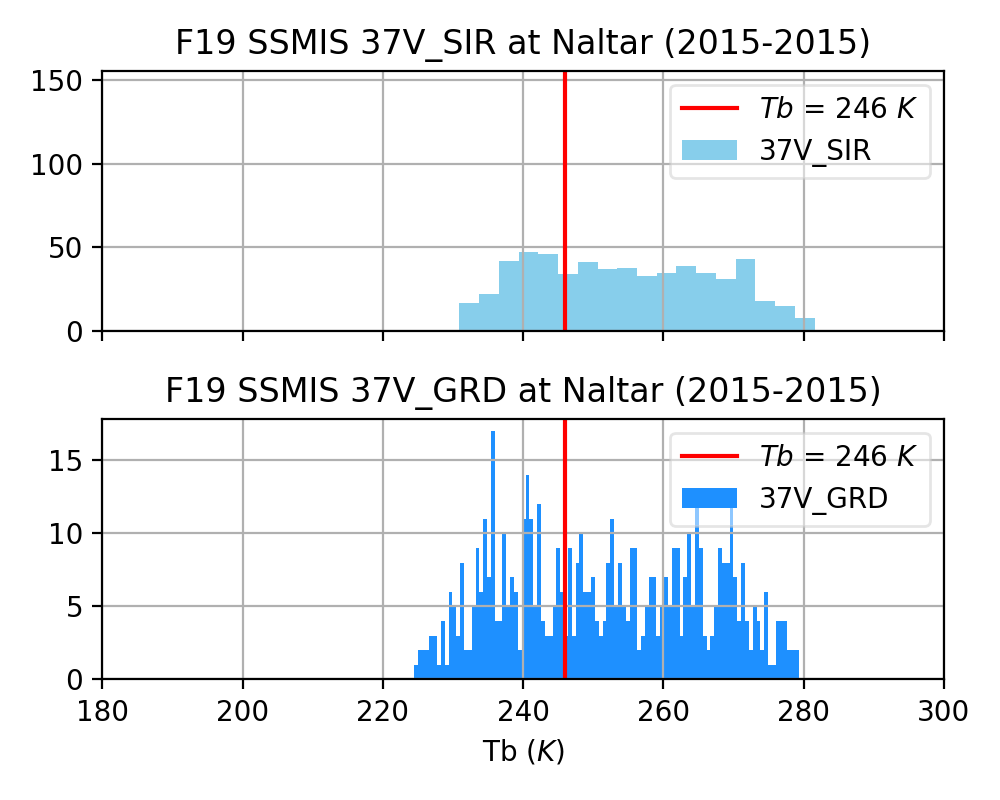

Saved hist to /projects/brodzik/pmesdr_melt_onset/data/Naltar_F19_SSMIS_2015-2015_37V_rSIR_vs_GRD_TB_hist.png


In [56]:
do_tseries = False
stations = [Khunjerab, Ziarat, Naltar]
for station in stations:
    print(station)
    station_GRD = data_GRD['TB'][:, 
                                 station['row25km']:station['row25km']+1,
                                 station['col25km']:station['col25km']+1].flatten()
    station_SIR = data_SIR['TB'][:, 
                                 station['row3km']:station['row3km']+1,
                                 station['col3km']:station['col3km']+1].flatten()

    grd_col_name = "%s_GRD" % channel
    sir_col_name = "%s_SIR" % channel
    df = pd.DataFrame(data=station_GRD, index=data_GRD['cal_date'], columns=[grd_col_name])
    df[sir_col_name] = station_SIR
    #print(df)

    # Plot Tb data
    if do_tseries:
        fig, ax = plt.subplots(2,1, figsize=(4,2.5))
        df[sir_col_name].plot(ax=ax[0], label=sir_col_name, color='skyblue')
        df[grd_col_name].plot(ax=ax[1], label=grd_col_name, color='dodgerblue')
        ax[0].set_title("%s %s %s at %s" % (platform, sensor, sir_col_name, station['name']))
        ax[1].set_title("%s %s %s at %s" % (platform, sensor, grd_col_name, station['name']))
        plt.tight_layout()
        outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_%s_rSIR_vs_GRD_TB_tseries.png' % (
            station['name'], platform, sensor, Years[0], Years[-1], channel)
        fig.savefig(outfile, dpi=300)
        print("Saved plot to %s" % outfile)

    # Do histograms of each
    fig, axes = plt.subplots(2,1, figsize=(5, 4), sharex=True)
    nbins = 100
    df[sir_col_name].hist(ax=axes[0], label=sir_col_name, bins=nbins, color='skyblue')
    df[grd_col_name].hist(ax=axes[1], label=grd_col_name, bins=nbins, color='dodgerblue')
    axes[0].set_title("%s %s %s at %s (%d-%d)" % (platform, sensor, sir_col_name, station['name'],
                                                  Years[0], Years[-1]))
    axes[1].set_title("%s %s %s at %s (%d-%d)" % (platform, sensor, grd_col_name, station['name'],
                                                  Years[0], Years[-1]))
    
    axes[1].set_xlabel("Tb ($K$)")
    
    axes[0].set_xlim(180., 300.)

    # Add a line for Tb threshold
    for ax in axes:
        ax.axvline(x=Tb_threshold, color='red',
                   linestyle="-", 
                   label="$Tb$ = %d $K$" % Tb_threshold)
        ax.legend(framealpha=0.5, loc='upper right')
        
    plt.tight_layout()

    outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_%s_rSIR_vs_GRD_TB_hist.png' % (
        station['name'], platform, sensor, Years[0], Years[-1], channel)
    fig.savefig(outfile, dpi=300)
    print("Saved hist to %s" % outfile)

In [ ]:
# Plot subset where there is snow
channel='36V'
grd_col_name = "%s_GRD" % channel
sir_col_name = "%s_SIR" % channel
fig, ax = plt.subplots(2,1)
sub_sir_df[sir_col_name].plot(ax=ax[0], label=sir_col_name, color='skyblue')
sub_grd_df[grd_col_name].plot(ax=ax[1], label=grd_col_name, color='dodgerblue')
ax[0].set_title("%s %s %s at %s" % (platform, sensor, sir_col_name, station['name']))
ax[1].set_title("%s %s %s at %s" % (platform, sensor, grd_col_name, station['name']))
plt.tight_layout()
#fig.savefig("./test.SIR-avg-std-min-max.t%03d.png" % (bandnum-1), dpi=300)



In [ ]:
# Hist only where GRD_snow is valid
DAV_threshold=40
Tb_threshold=252

# Do histograms of each
fig, axes = plt.subplots(2,1, sharex=True)
nbins = 100
sub_sir_df[sir_col_name].hist(ax=axes[0], label=sir_col_name, bins=nbins, color='skyblue')
sub_grd_df[grd_col_name].hist(ax=axes[1], label=grd_col_name, bins=nbins, color='dodgerblue')
axes[0].set_title("%s %s %s at %s" % (platform, sensor, sir_col_name, station['name']))
axes[1].set_title("%s %s %s at %s" % (platform, sensor, grd_col_name, station['name']))

# Add a line for Tb threshold
for ax in axes:
    ax.axvline(x=Tb_threshold, color='red',
               linestyle="-", 
               label="$Tb$ threshold")
    ax.legend(framealpha=0.5, loc='upper right')
plt.tight_layout()

outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_%s_rSIR_vs_GRD_TB_hist_wSnow.png' % (
    station['name'], platform, sensor, Years[0], Years[-1], channel)
fig.savefig(outfile, dpi=300)
print("Saved hist to %s" % outfile)